# Deconvolution with two images

In [here](http://localhost:8888/notebooks/notebooks/2018-06%20-%20Deconvolution%20with%20Consecutive%20Deconvolution%20estimates.ipynb) and here I demonstrated that applying FRC to deconvolution results is rather challenging, as the deconvolution process make cause for the two images to strongly correlate. Here I show how the deconvolution results can be successfully evaluated with FRC using the checkerboard split method.

In [80]:
%matplotlib inline

import os
import numpy as np

import supertomo.data.io.read as imread
import supertomo.ui.plots.image as showim
from supertomo.psf import psfgen
from supertomo.data.containers.image import Image


from supertomo.processing.deconvolution import deconvolve
from supertomo.data.wrappers import image_writer_wrappers as imwrap



Load *Carma* file into the internal image container class. Then generate a theoretical PSF for deconvolution.

In [81]:
# Image
data_dir = "/Users/sami/Documents/Work/Data/2018_05_FSC_paper/2018_01_29_FRC_Nikon_Taka"
image1_name = "FRC_GaAsP_AU04_.nd2"
image2_name = "FRC_GaAsP_AU04.nd2"

image1 = imread.get_image(os.path.join(data_dir, image1_name))
image2 = imread.get_image(os.path.join(data_dir, image2_name))

image1 = Image(image1 - image1.min(), image1.spacing)
image2 = Image(image2 - image2.min(), image2.spacing)

image_copy = image1.copy()
image_copy.spacing = image1.spacing
spacing = image1.spacing
print "The image dimensions are {} and spacing {} um.".format(image1.shape, image1.spacing)

The image dimensions are (512, 512) and spacing [0.05179004745018662, 0.05179004745018662] um.


Setting up registration job
Starting registration
Final metric value: -0.934317392028
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Step too small after 20 iterations. Current step (0.000470185) is less than minimum step (0.0005).


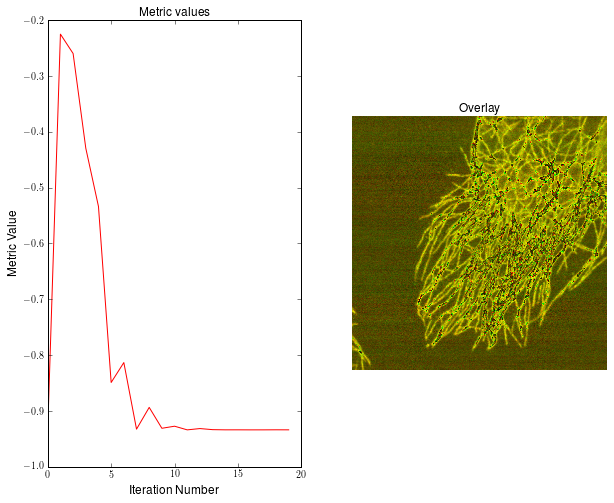

In [82]:
import supertomo.ui.supertomo_options as options
from supertomo.processing.registration import registration
from supertomo.processing import itk

fixed_image = itk.convert_to_itk_image(image1)
moving_image = itk.convert_to_itk_image(image2)


args_list = ("path --sampling-percentage=1 --reg-relax-factor=.6 --learning-rate=1 --min-step=0.0005 "         
        "--reg-max-iterations=300 --reg-method=correlation --reg-translate-only " 
        "--reg-enable-observers").split()

args = options.get_ism_script_options(args_list)

transform = registration.itk_registration_rigid_2d(fixed_image, moving_image, args)



In [83]:
image2 = itk.convert_from_itk_image(itk.resample_image(moving_image, transform))

print transform

itk::simple::Transform
 TranslationTransform (0x7fe9ff578450)
   RTTI typeinfo:   itk::TranslationTransform<double, 2u>
   Reference Count: 2
   Modified Time: 7399749
   Debug: Off
   Object Name: 
   Observers: 
     none
   Offset: [0.0057111, 0.00352421]



In [84]:

def get_confocal_psf(ndim, ex_wavelen=488, em_wavelen=525, na=1.45, refr_index=1.5, 
                     pinhole=.4, magnification=60, sted=False):

    psf = psfgen.PSF(psfgen.GAUSSIAN | psfgen.CONFOCAL, shape=(128,128), ex_wavelen=ex_wavelen, 
                          em_wavelen=em_wavelen, num_aperture=na, refr_index=refr_index, 
                          pinhole_radius=pinhole, magnification=magnification )
    if sted:
        psf.sted_correction()
        
    psf_image = psf.volume()
    psf_spacing = (psf.dims['um'][0]/psf.shape[0],)*3

    if ndim == 2:
        psf_image = psf_image[psf_image.shape[0]/2]
        psf_spacing = psf_spacing[:-1]

    return Image(psf_image, psf_spacing)

psf = get_confocal_psf(2)

print "Succesfully generated a theoretical PSF."
print "The image dimensions are {} and spacing {}.".format(psf.shape, psf.spacing)


Succesfully generated a theoretical PSF.
The image dimensions are (255, 255) and spacing [0.03125, 0.03125].


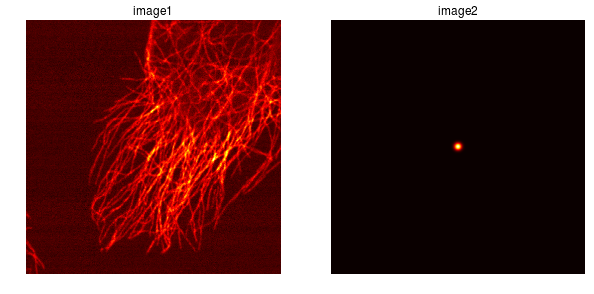

In [85]:
showim.display_2d_images(image1, psf)

Run deconvolution

# Deconvolve Image 1

In [86]:
from supertomo.ui import deconvolution_options as options
n_iterations = 40
args_list = ("image psf"  
             " --max-nof-iterations={}  --first-estimate=image " 
             " --blocks=1 --pad=0 --save-intermediate-results --resolution-threshold-criterion=fixed "
             " --bin-delta=14 --frc-curve-fit-degree=4 --use-splines "
             " --resolution-threshold-value=0.6").format(n_iterations).split()
            
args = options.get_deconvolve_script_options(args_list)

In [87]:
image_1_results_dir = os.path.join(data_dir, "image_1_results")
image_2_results_dir = os.path.join(data_dir, "image_2_results")

if not os.path.exists(image_1_results_dir):
    os.mkdir(image_1_results_dir)
    
writer = imwrap.TiffImageWriter(image_1_results_dir)

deconvolution_task_1 = deconvolve.DeconvolutionRL(image1, psf, writer, args)
deconvolution_task_1.execute()

The original image size is (512, 512)
The deconvolution will be run with 1 blocks
The internal block size is (512, 512)
Preparing image fusion.
Beginning the computation of the 0. estimate
[>                 1/40                ] E/S/U/N=0/21093282/14260121/0, LEAK=-0.748941737113%, TAU1=0.0518488138914, TIME=0.112s, U/ESU=0.403 
Beginning the computation of the 1. estimate
[=>                2/40                ] ETA:3.4s E/S/U/N=81/26812382/8569193/0, LEAK=-0.829458326636%, TAU1=0.0348373353481, TIME=8.46E-2s, U/ESU=0.242 
Beginning the computation of the 2. estimate
[==>               3/40                ] ETA:3.2s E/S/U/N=0/29795634/5576758/0, LEAK=-0.803054159704%, TAU1=0.0277159269899, TIME=7.69E-2s, U/ESU=0.158 
Beginning the computation of the 3. estimate
[===>             4/40                 ] ETA:3.1s E/S/U/N=98/31307705/4051145/0, LEAK=-0.764744438726%, TAU1=0.0237155500799, TIME=8.05E-2s, U/ESU=0.115 
Beginning the computation of the 4. estimate
[====>            5/40     

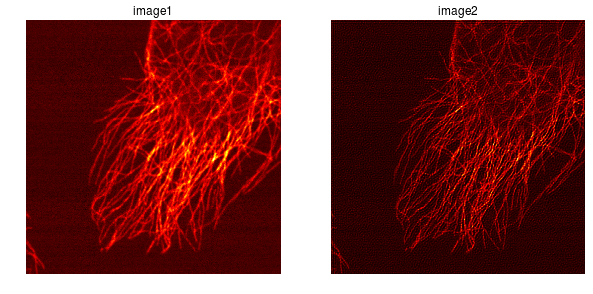

In [88]:
result = deconvolution_task_1.get_8bit_result()

showim.display_2d_images(image1, result)



## Deconvolve Image 2

In [89]:
image_2_results_dir = os.path.join(data_dir, "image_2_results")

if not os.path.exists(image_2_results_dir):
    os.mkdir(image_2_results_dir)
    
writer = imwrap.TiffImageWriter(image_2_results_dir)

deconvolution_task_2 = deconvolve.DeconvolutionRL(image2, psf, writer, args)
deconvolution_task_2.execute()

The original image size is (512, 512)
The deconvolution will be run with 1 blocks
The internal block size is (512, 512)
Preparing image fusion.
Beginning the computation of the 0. estimate
[>                 1/40                ] E/S/U/N=0/20197774/13805420/0, LEAK=-0.738539510499%, TAU1=0.0517777428031, TIME=0.120s, U/ESU=0.406 
Beginning the computation of the 1. estimate
[=>                2/40                ] ETA:4.7s E/S/U/N=0/25943585/8082892/0, LEAK=-0.807519280446%, TAU1=0.0345289744437, TIME=0.119s, U/ESU=0.238 
Beginning the computation of the 2. estimate
[==>               3/40                ] ETA:4.3s E/S/U/N=0/28839254/5175862/0, LEAK=-0.773860143821%, TAU1=0.0273427721113, TIME=0.106s, U/ESU=0.152 
Beginning the computation of the 3. estimate
[===>             4/40                 ] ETA:3.9s E/S/U/N=156/30295938/3704682/0, LEAK=-0.731375678607%, TAU1=0.0233272332698, TIME=8.64E-2s, U/ESU=0.109 
Beginning the computation of the 4. estimate
[====>            5/40         

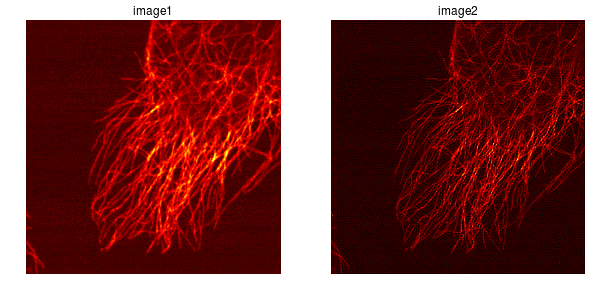

In [90]:
result = deconvolution_task_2.get_8bit_result()

showim.display_2d_images(image1, result)



In [91]:
import supertomo.analysis.resolution.fourier_ring_correlation as frc
import supertomo.analysis.resolution.analysis as frc_analysis
import supertomo.data.io.read as read
from supertomo.data.containers.fourier_correlation_data import FourierCorrelationDataCollection
import supertomo.analysis.resolution.analysis as fsc_analysis
import supertomo.processing.image as imops
from math import sqrt
import supertomo.processing.windowing as window
frc_data = FourierCorrelationDataCollection()


for idx in range(n_iterations):
    image_name = "result_{}.tif".format(idx)

    image1_path = os.path.join(image_1_results_dir, image_name)
    image2_path = os.path.join(image_2_results_dir, image_name)


    image1 = read.get_image(image1_path)
    image2 = read.get_image(image2_path)
    
    image1 = Image(window.apply_hamming_window(image1), spacing)
    image2 = Image(window.apply_hamming_window(image2), spacing)

    frc_task = frc.FRC(image1, image2, args.d_bin)
    frc_data[idx] = frc_task.execute()
                 

analyzer = fsc_analysis.FourierCorrelationAnalysis(frc_data, spacing[0], args)
results = analyzer.execute()


Fit starts at 0.4375
Optimization terminated successfully.
         Current function value: 0.000102
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.4375
Optimization terminated successfully.
         Current function value: 0.000052
         Iterations: 11
         Function evaluations: 22
Fit starts at 0.4375
Optimization terminated successfully.
         Current function value: 0.000060
         Iterations: 11
         Function evaluations: 22
Fit starts at 0.4375
Optimization terminated successfully.
         Current function value: 0.000133
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.4375
Optimization terminated successfully.
         Current function value: 0.000054
         Iterations: 11
         Function evaluations: 22
Fit starts at 0.4375
Optimization terminated successfully.
         Current function value: 0.000126
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.4375
Optimization terminated s

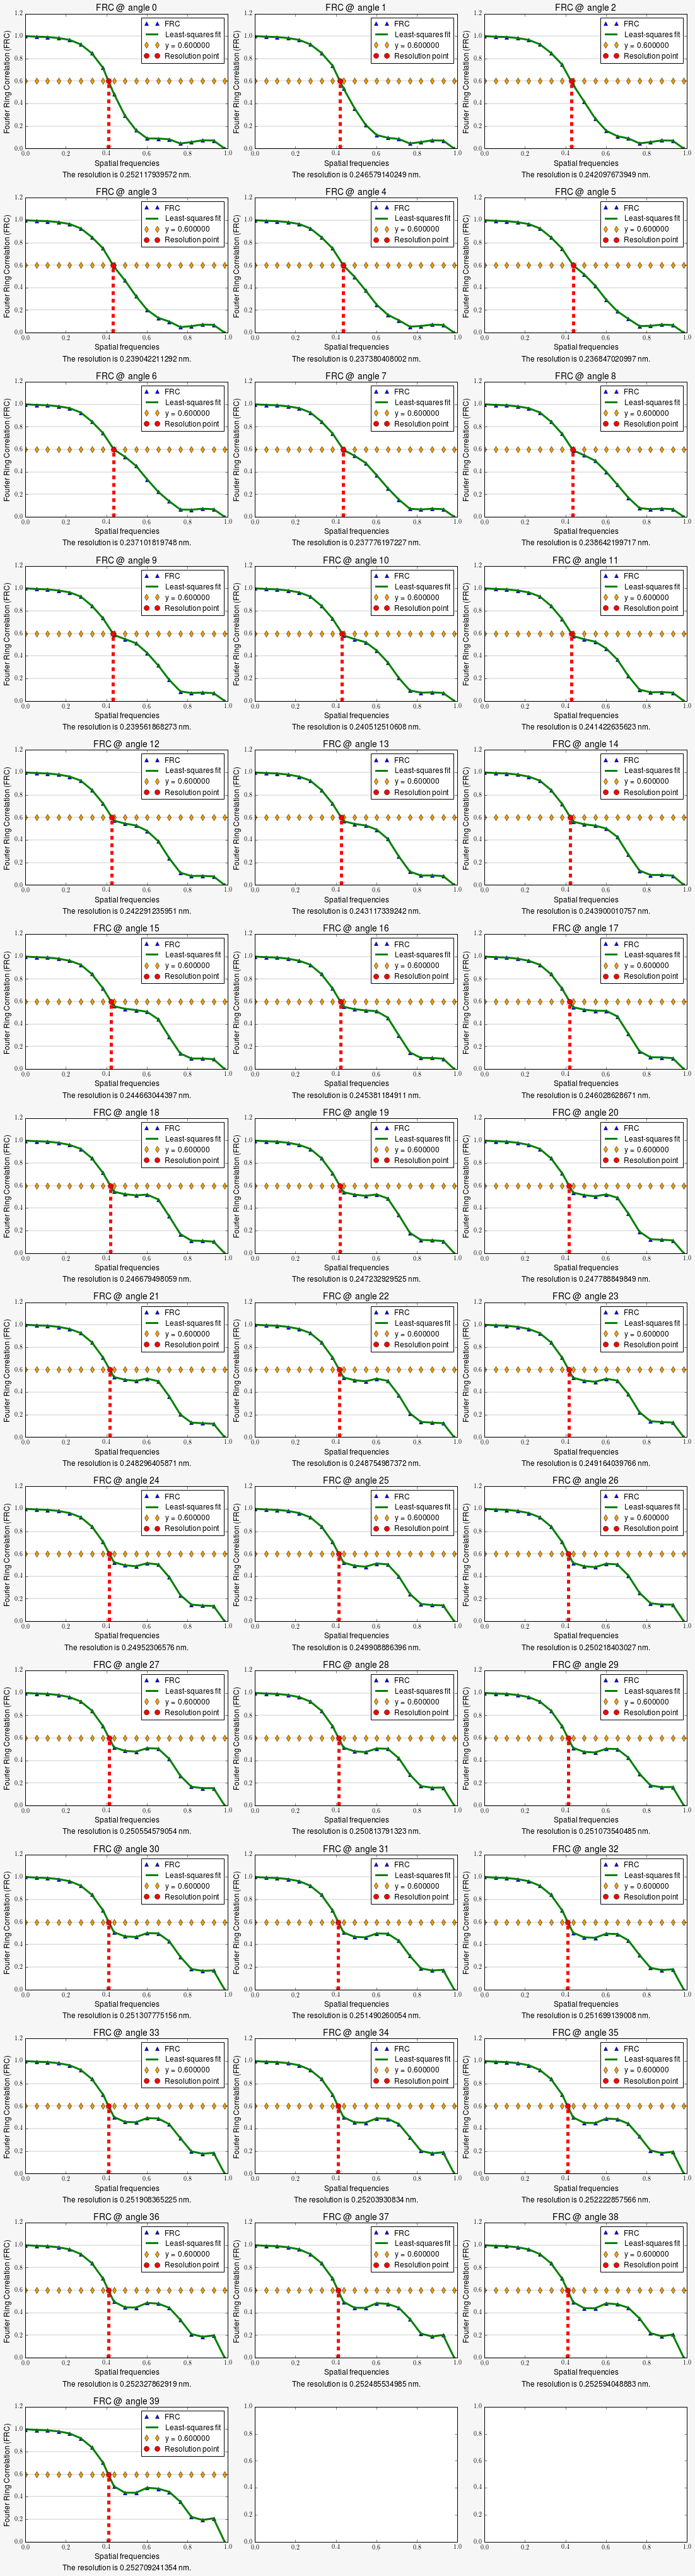

In [92]:
import supertomo.ui.plots.frc as frcplots

plotter = frcplots.FourierDataPlotter(results)
plotter.plot_all()

## Regarding the measured FRC values

I wanted to see look more closely into how the FRC values behave as a function of the iteration count. The *SuperTomo* deconvolution algorithm also calculates several parameter values that have traditionally been used to evaluate the progress of an iterative deconvolution. For more info, look at (Koho et al 2014). 

Here I normalize all the parameter values (0-1) for easy comparison and plotting. The original values are maintained in the *deconvolution_parameters* dataframe.

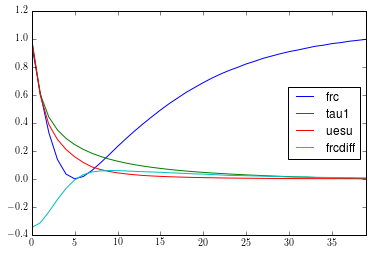

In [93]:
# Get a list of the resolution values as a function of iteration number
iterations = list()
resolutions = list()

for dataset in results:
    iterations.append(int(dataset[0]))
    resolutions.append(dataset[1].resolution["resolution"])

iterations, resolutions = zip(*sorted(zip(iterations, resolutions)))

# Get saved deconvolution parameters
deconvolution_parameters = deconvolution_task_1.progress_parameters
#deconvolution_parameters_2 = deconvolution_task_2.progress_parameters

deconvolution_parameters['frc'] = resolutions


# Set up curves
curves = deconvolution_parameters.loc[:, ['frc', 'tau1', 'uesu']]

curves['frc'] -= curves['frc'].min()
curves['frc'] /= curves['frc'].max()

curves['tau1'] -= curves['tau1'].min()
curves['tau1'] /= curves['tau1'].max()

curves['uesu'] -= curves['uesu'].min()
curves['uesu'] /= curves['uesu'].max() 

curves['frcdiff'] = np.gradient(curves['frc'])



curves.plot()

## Regarding the FRC resolution curve

The FRC resolution value curve behaves in a very interestin way. It is first of all much more linear than *u_esu* and *tau1* and what is quite extraordinary,  the FRC value is able to discern the iteration after which the RL algorithm stops fitting the data, and mainly starts amplifying the noise.

In [94]:
zero_crossing = np.where(np.diff(np.sign(curves['frcdiff'])))[0][0]

print "The deconvolution should be stopped at iteration {}.".format(zero_crossing)

#print zero_crossing

The deconvolution should be stopped at iteration 5.


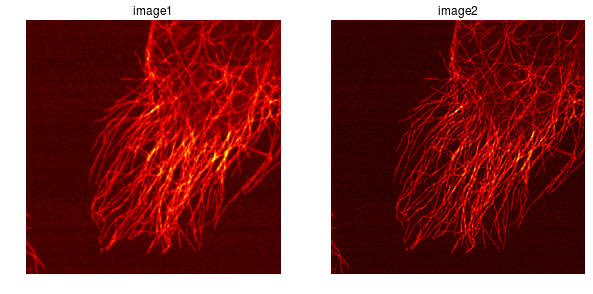

In [95]:
image_path = os.path.join(image_1_results_dir, "result_{}.tif".format(zero_crossing))

result_image = read.get_image(image_path)
result_image *= 255/result_image.max()

showim.display_2d_images(image_copy, result_image)


